In [1]:
###################################################################################
#Conversion of weighted macro-particle distributions-V.1- 15-03-24 
#Author: Nicolas Pichoff. Adapted to Python language by: Samuel Marini-- Reference article: https://arxiv.org/pdf/2403.10645v1.pdf
###################################################################################
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib import rc
import h5py

# Determine the source of macroparticle data.
# Setting particles_from_file to False initiates the creation of a synthetic macroparticle distribution with N macroparticles.
# Setting it to True imports the macroparticle data from an FBPIC output file.
particles_from_file = False

# Specifies the number of macroparticles in the initial distribution, applicable only if particles_from_file is False.
N = 1000000

# The intended number of macroparticles in the (final) distribution.
Np = 10000

# Configures the weighting scheme for transformed macroparticles in the final distribution.
# Use choix = 1 for a uniform weight distribution (w_j = 1) among transformed macroparticles.
# Use choix = 2 to base the distribution on the square root of the initial weights (w_j = sqrt{w_i}).
choix = 1

# The phi parameter defines the error margin. Use phi << 1 for enhanced precision, as detailed on page 4 of the reference article
phi = 0.1


Gamma_initial= 1.9088166351514555
Gamma_final= 1.9054327119009726
relative gamma error= -0.17727859178125663
Number of particles (initial)= 1000000
Equivalent number of particles (initial)= 7447
Number of particles (final)= 10138
Equivalent number of particles (final)= 10138

*** Matrix Sigma P (original centred-normalized) ***
 [[ 1.        0.00987  -0.001808 -0.000034  0.001355 -0.000489]
 [ 0.00987   1.       -0.006048 -0.002886  0.005133  0.001625]
 [-0.001808 -0.006048  1.       -0.005567  0.006023  0.005532]
 [-0.000034 -0.002886 -0.005567  1.        0.003009  0.006778]
 [ 0.001355  0.005133  0.006023  0.003009  1.        0.001287]
 [-0.000489  0.001625  0.005532  0.006778  0.001287  1.      ]]

*** Difference Matrix Sigma Q'-Q (centred-normalized-decupled) ***
 [[ 0.013471 -0.003039 -0.006285 -0.003958 -0.000749 -0.005048]
 [-0.003039  0.005882  0.01167   0.005178  0.006863  0.00361 ]
 [-0.006285  0.01167   0.023162  0.003815 -0.007525 -0.009574]
 [-0.003958  0.005178  0.003815 

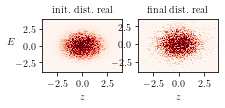

In [2]:

#############################################################
# Step one - Provide the initial distribution of macroparticles
#############################################################

# If not loading particle data from a file, generate a distribution.
if not particles_from_file: 
    np.random.seed(939393)  # Set seed for reproducibility
    p_rnd = 4 * (2 * np.random.rand(6, N) - 1)  # Randomly generate initial positions and momenta
    w = np.exp(-0.5 * np.sum(p_rnd ** 2, axis=0))  # Calculate weights based on Gaussian distribution
    p = np.zeros((6, N))  # Initialize the 6D position and momentum array
    for i in range(6):
        p[i, :] = p_rnd[i, :]  # Populate the position and momentum array with random values
    
# If loading particle data from a file, extract the data.
else:
    output = 36  # Identifier for the dataset
    gamma_selection_min = 50  # Minimum gamma to filter out slow particles
    gamma_selection_max = None  # Optional maximum gamma for filtering

    f = h5py.File('data00000036.h5', 'r')  # Open the data file
    data = f['data'][str(output)]
    particles = data['particles']
    electrons = particles['electrons'] 

    # Extract momenta and positions
    momentum = electrons['momentum'] 
    position = electrons['position'] 
    w = np.array(electrons['weighting'])

    # Normalize momenta to units of c
    ux = np.array(momentum['x']) / (const.m_e * const.c)
    uy = np.array(momentum['y']) / (const.m_e * const.c)
    uz = np.array(momentum['z']) / (const.m_e * const.c)

    # Positions
    x = np.array(position['x'])
    y = np.array(position['y'])
    z = np.array(position['z'])

    # Filter particles based on gamma
    gamma_temp = np.sqrt(1 + ux**2 + uy**2 + uz**2)
    Energy_temp = (gamma_temp - 1) * const.m_e * const.c**2 / const.e * 1e-6
    indexes_to_keep = np.where((gamma_temp > gamma_selection_min) & (gamma_temp < gamma_selection_max if gamma_selection_max is not None else True))
    
    # Applying filters
    for var in [w, ux, uy, uz, x, y, z, gamma_temp, Energy_temp]:
        var[:] = var[indexes_to_keep]

    N = len(w)  # Update the number of particles based on the energy filter
    p = np.zeros((6, N))  # Initialize 6D array for positions and momenta
    p[0, :], p[1, :], p[2, :], p[3, :], p[4, :], p[5, :] = x, y, z, ux, uy, uz





#############################################################
# Step two- handle the initial distribution
#############################################################

W = np.sum(w)  # Total weight of initial distribution
Neq = np.sum(w) ** 2 / np.sum(w ** 2)  # Equivalent number of particles for statistical analysis

# Initialization of the Sigma matrix for the 6D distribution: p
Avp = np.zeros(6)  # Average position and momentum
Sigp = np.zeros((6, 6))  # Covariance matrix

# Calculate the average of each component
for i in range(6):
    Avp[i] = np.sum(w * p[i, :]) / W   

# Calculate the covariance matrix for the 6D distribution
for i in range(6):
    for j in range(6):
        Sigp[i, j] = np.sum(w * (p[i, :] - Avp[i]) * (p[j, :] - Avp[j])) / W






#############################################################
# Step three - Centralize and normalize the initial distribution
#############################################################

# Normalize the initial 6D distribution (p) to obtain P.
# This process involves shifting by the mean and scaling by the standard deviation for each dimension.
P = np.zeros((6, N))
for i in range(6):
    P[i, :] = (p[i, :] - Avp[i]) / np.sqrt(Sigp[i, i])

# Compute the average and sigma matrix for the normalized distribution P.
AvP = np.zeros(6)  # Averages of the normalized distribution
SigP = np.zeros((6, 6))  # Covariance matrix of the normalized distribution

for i in range(6):
    AvP[i] = np.sum(w * P[i, :]) / W  # Recalculate averages for P

# Calculate the sigma matrix for the normalized 6D distribution P.
for i in range(6):
    for j in range(6):
        SigP[i, j] = np.sum(w * (P[i, :] - AvP[i]) * (P[j, :] - AvP[j])) / W






#############################################################
# Step four - Uncoupling the centralized and normalized distribution
#############################################################
        
# Determine the lower triangular matrix T that transforms the sigma matrix into an identity matrix.
# This step is essential for orthogonalizing and unit-normalizing the distribution.
T = np.zeros((6, 6))
for i in range(6):
    for j in range(i):
        T[i, j] = (SigP[j, i] - np.sum(T[i, :j] * T[j, :j])) / T[j, j]  # Calculation based on eq. (16)
    T[i, i] = np.sqrt(SigP[i, i] - np.sum(T[i, :i] ** 2))  # Calculation based on eq. (17)      

# Apply the inverse of the transformation matrix T to P, resulting in the uncoupled distribution Q.
# This process decorrelates the dimensions of the distribution.
Q = np.linalg.inv(T) @ P

# Calculate the average (AvQ) and the sigma matrix (SigQ) for the uncoupled distribution Q.
# The goal is to verify that the distribution is now uncoupled, ideally leading to an identity matrix for SigQ.
AvQ = np.zeros(6)  # Averages of the uncoupled distribution
SigQ = np.zeros((6, 6))  # Covariance matrix of the uncoupled distribution

for i in range(6):
    AvQ[i] = np.sum(w * Q[i, :]) / W  # Compute averages for Q

# Calculate the sigma matrix for the uncoupled 6D distribution Q.
for i in range(6):
    for j in range(6):
        SigQ[i, j] = np.sum(w * (Q[i, :] - AvQ[i]) * (Q[j, :] - AvQ[j])) / W







#############################################################
# Step five - Create the new distribution
#############################################################

# Use the final weights based on the choix parameter.
if choix == 1:
    w2 = np.ones(N)  # Define uniform weights for the final distribution.
elif choix == 2:
    w2 = np.sqrt(w)  # Adjust weights to reduce their variance, making the distribution more uniform.
else:
    w2 = np.ones(N)  # Default to uniform weights for any other choix value.

# Calculate the total weight of the new distribution.
W2 = np.sum(w2)

# Calculate the parameter nu (Eq.8)
# This is determined by scaling the ratio of new and old weights and normalized to the final particle count.
nu = w / w2 * W2 / W
nu = nu / np.sum(nu) * Np

# Initialize the new particle array and corresponding weights, slightly overestimating the final number to ensure capacity.
# The seed is set for reproducibility of the random processes.
np.random.seed(123456789)
np.random.default_rng(123456789)
Qpt = np.zeros((6, int(1.1 * Np)))
wpt = np.zeros(int(1.1 * Np))


Neq2 = np.sum(w2) ** 2 / np.sum(w2 ** 2)  # Approx number of particles in the new distribution 
dsig = phi/np.sqrt(2*Neq2) #distance of the particles-- it must be small to avoid error


# Generate the new distribution by reallocating particles according to their calculated averages
j = 1  # Initialize counter for the new particles
for i in range(N):  # Iterate through all initial particles
    if nu[i] > 1:
        np_i = int(np.floor(nu[i]))  # Determine the base number of new particles to generate from this original particle
        if np.random.rand() <= (nu[i] - np_i):  # Add an additional particle based on the fractional part of nu[i]
            np_i += 1
        for k in range(np_i):  # Generate the new particles
            Qpt[:, j-1] = Q[:, i] + np.random.randn(6) * dsig  # Add random variation within a hypersphere defined by dsig
            wpt[j-1] = w2[i]  # Assign the new weight
            j += 1
    else:
        if np.random.rand() <= nu[i]:  # For particles with nu[i] < 1, decide randomly if a new particle is generated
            Qpt[:, j-1] = Q[:, i]  # No additional variation is added
            wpt[j-1] = w2[i]
            j += 1

# Finalize the new distribution, trimming the arrays to the actual number of new particles created.
Npf = j - 1  # Final count of new particles
Qp = Qpt[:, :Npf]  # New particle positions and momenta
wp = wpt[:Npf]  # New particle weights
Wpf = np.sum(wp)  # Total weight of the new distribution

# Calculate the average and sigma matrix for the new distribution Q'.
AvQp = np.zeros(6)  # Averages of the new distribution
SigQp = np.zeros((6, 6))  # Covariance matrix of the new distribution
for i in range(6):
    AvQp[i] = np.sum(wp * Qp[i, :]) / Wpf
for i in range(6):
    for j in range(6):
        SigQp[i, j] = np.sum(wp * (Qp[i, :] - AvQp[i]) * (Qp[j, :] - AvQp[j])) / Wpf






#############################################################
# Step six - Transform the new distribution back to the original space
#############################################################

# Transform the uncoupled new distribution (Q') back to the normalized space (P').
Pp = T @ Qp  # Apply the transformation matrix T

# Calculate the sigma matrix for the transformed distribution P'.
AvPp = np.zeros(6)  # Averages of P'
SigPp = np.zeros((6, 6))  # Covariance matrix of P'

for i in range(6):
    AvPp[i] = np.sum(wp * Pp[i, :]) / Wpf
    for j in range(6):
        SigPp[i, j] = np.sum(wp * (Pp[i, :] - AvPp[i]) * (Pp[j, :] - AvPp[j])) / Wpf

# Transform the normalized distribution (P') back to the initial space (p').
pp = np.zeros((6, Npf))  # Initialize array for the final particle positions and momenta
for i in range(6):
    pp[i, :] = Avp[i] + np.sqrt(Sigp[i, i]) * Pp[i, :]  # Scale and shift according to the original distribution's parameters

# Calculate the sigma matrix for the final distribution p'.
Avpp = np.zeros(6)  # Averages of p'
Sigpp = np.zeros((6, 6))  # Covariance matrix of p'
for i in range(6):
    Avpp[i] = np.sum(wp * pp[i, :]) / Wpf
    for j in range(6):
        Sigpp[i, j] = np.sum(wp * (pp[i, :] - Avpp[i]) * (pp[j, :] - Avpp[j])) / Wpf




        
###############################################################
# Step seven - Results presentation
###############################################################
        
# Calculate gamma for the initial distribution.
gammai = np.sqrt(1 + p[3, :]**2 + p[4, :]**2 + p[5, :]**2)
Gamma_initial = np.sum(w * gammai) / np.sum(w)
print('Gamma_initial=', Gamma_initial)

# Calculate gamma for the final distribution.
gammaf = np.sqrt(1 + pp[3, :]**2 + pp[4, :]**2 + pp[5, :]**2)
Gamma_final = np.sum(wp * gammaf) / np.sum(wp)
print('Gamma_final=', Gamma_final)

# Calculate the relative error in the gamma value before and after the transformation.
print('relative gamma error=', 100 * (Gamma_final - Gamma_initial) / Gamma_initial)

# ************************************************************
# *** Results: Evaluating the transformation effectiveness ***
# ************************************************************

# Calculate and display the initial and final equivalent number of particles.
Neq = np.sum(w)**2 / np.sum(w**2)  # Initial equivalent number
print('Number of particles (initial)= {}'.format(N))
print('Equivalent number of particles (initial)= {}'.format(int(Neq)))

Neqf = np.sum(wp)**2 / np.sum(wp**2)  # Final equivalent number
print('Number of particles (final)= {}'.format(Npf))
print('Equivalent number of particles (final)= {}'.format(int(Neqf)))
###############################################################


###############################################################
# Enhancing the representation of matrices for improved clarity
###############################################################
np.set_printoptions(precision=6, suppress=True)


# # print('\n*** Matrix Sigma p (original) ***\n', Sigp)
# # print('\n******************************************************************\n')
# # print('\n*** Matrix Sigma P (original centred-normalized) ***\n', SigP)
# # print('\n******************************************************************\n')
# # print('\n*** Matrix Sigma Q (original centred-normalized) ***\n', SigQ)
# # print('\n******************************************************************\n')
# # print('\n*** Matrix Sigma Q\' (new centred-normalized-decupled) ***\n', SigQp)
# # print('\n******************************************************************\n')
# # print('\n*** Matrix Sigma p\' (new) ***\n', Sigpp)
# # print('\n******************************************************************\n')
# # print('\n*** Difference Matrix Sigma Q\'-Q (centred-normalized-decupled) ***\n', SigQp - SigQ)


print('\n*** Matrix Sigma P (original centred-normalized) ***\n', SigP)
print('\n*** Difference Matrix Sigma Q\'-Q (centred-normalized-decupled) ***\n', SigQp - SigQ)






###############################################################
# Step eight - Figure presentation
###############################################################
# Configuration for plot aesthetics using matplotlib and LaTeX for text rendering.
fs = 10  # Font size for ticks
rc('text', usetex=True)  # Enable LaTeX rendering
rc('font', family='serif')  # Serif font for a classic academic look
rc('xtick', labelsize=fs)  # X tick label size
rc('ytick', labelsize=fs)  # Y tick label size

# Determine figure size in inches (conversion from cm), maintaining an aspect ratio.
figsizeX = 8 / 2.54  # Size in x (width)-- 8cm
figsizeY = 8 / 2.54 / (2*1.61803398875)  # Size in y (height), with a specific aspect ratio

plt.figure(figsize=(figsizeX, figsizeY))

# Plotting the initial distribution.
plt.subplot(121)  # First subplot in a 1x2 grid
varX = p[2, :]  # Position variable (z)
varY = p[5, :]  # Energy variable (E)
vmax = 0.0006  # Maximum value for color normalization
plt.hist2d(varX, varY, bins=100, cmap='Reds', weights=w / np.sum(w), norm=Normalize(vmin=0, vmax=vmax))
plt.xlabel("$z$", fontsize=fs)
plt.ylabel("$E$", fontsize=fs, rotation=0)
plt.title("init. dist. real", fontsize=fs)

# Plotting the final distribution.
plt.subplot(122)  # Second subplot in the 1x2 grid
varX = pp[2, :]  # Updated position variable (z) for the final distribution
varY = pp[5, :]  # Updated energy variable (E) for the final distribution
plt.hist2d(varX, varY, bins=100, cmap='Reds', weights=wp / np.sum(wp), norm=Normalize(vmin=0, vmax=vmax))
plt.xlabel("$z$", fontsize=fs)
plt.title("final dist. real", fontsize=fs)
#plt.show()
plt.savefig("fig.pdf")






# ###############################################################
# # Step nine - Figure presentation in the centralized normalize and uncupled frame
# ###############################################################

# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.ticker import MultipleLocator
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# # Define common figure parameters.
# fs = 9  # font size.
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# plt.rc('axes', linewidth=0.3)
# plt.rcParams.update({'font.size': fs})


# figsize = 3.9/ 2.54  # Convert size from cm to inches.
# aspect_ratio = 1.3
# xmin, xmax, ymin, ymax = 0, 50, 0, 50  # Axis ranges.

# # Function to generate images for both initial and final distributions.
# def generate_image(distribution, weights, label, filename_suffix):
#     # Initialize the image array.
#     image = 1e-10 * np.ones((50, 50))
#     for i in range(len(weights)):
#         ix = int(26 + 25 * distribution[0, i] / 5)
#         iy = int(26 + 25 * distribution[1, i] / 5)
#         if 0 < ix < xmax+1 and 0 < iy < ymax+1:
#             image[ix-1, iy-1] += weights[i]
    
#     fig, ax = plt.subplots(figsize=(figsize, figsize / aspect_ratio))
#     fig.subplots_adjust(bottom=0.18, left=0.21, right=0.89, top=0.93)
    
#     # Create contour plot.
#     W_total = np.sum(weights)
#     contour_levels = np.arange(-8, -1.5, 0.5)
#     plt.contourf(np.log10(image / W_total), levels=contour_levels, cmap='jet', vmin=-8, vmax=-2.0)
#     cbar = plt.colorbar()
#     cbar.ax.tick_params(labelsize=9, size=1, width=0.7)
    
#     ax.set_xlim([xmin, xmax])
#     ax.set_ylim([ymin, ymax])
#     ax.set_xticks([xmin, (xmax-xmin)/2, xmax])
#     ax.set_yticks([ymin, (xmax-xmin)/2, ymax])
#     ax.tick_params(axis='both', which='both', direction='in', width=0.4)
#     ax.tick_params(axis='both', which='minor', length=1)
#     ax.tick_params(which='both', size=3, width=0.2, direction='in', top=True, right=True)
    
#     # Set minor tick intervals.
#     minor_locator = MultipleLocator(xmax/10)
#     ax.xaxis.set_minor_locator(minor_locator)
#     ax.yaxis.set_minor_locator(minor_locator)

#     # Labels and text.
#     ax.set_xlabel('$x_1/\\sigma_1$', fontsize=fs+1, labelpad=0)
#     ax.set_ylabel('$x_2/\\sigma_2$', fontsize=fs+1, rotation=90, labelpad=0)
#     ax.text(0.03, 0.9, label, transform=ax.transAxes, fontsize=fs, horizontalalignment='left')
    
#     # Save the figure.
#     plt.savefig(f"fig{filename_suffix}.png", dpi=300)
#     plt.savefig(f"fig{filename_suffix}.pdf")

# # Generate images for both distributions- centralized normalize and uncupled before and after the transformation
# generate_image(Q, w,   '(a) initial', '1a')
# generate_image(Qp, wp, '(b) final', '1b')


